In [59]:
import torch
import torchvision.models as models
from torchsummary import summary 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim



In [42]:
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet-50 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


In [57]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(weights=True)

# Modify the final layer to fit CIFAR-10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\nq9093\AppData\Local\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [62]:
for epoch in range(2):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')


[Epoch 1, Batch 200] loss: 0.957
[Epoch 1, Batch 400] loss: 0.341
[Epoch 1, Batch 600] loss: 0.252
[Epoch 1, Batch 800] loss: 0.227
[Epoch 1, Batch 1000] loss: 0.215
[Epoch 1, Batch 1200] loss: 0.203
[Epoch 1, Batch 1400] loss: 0.188
[Epoch 2, Batch 200] loss: 0.121
[Epoch 2, Batch 400] loss: 0.103
[Epoch 2, Batch 600] loss: 0.097
[Epoch 2, Batch 800] loss: 0.099
[Epoch 2, Batch 1000] loss: 0.100
[Epoch 2, Batch 1200] loss: 0.106
[Epoch 2, Batch 1400] loss: 0.104
Finished Training


In [63]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total:.2f}%')


Accuracy of the network on the 10,000 test images: 94.49%


In [90]:
test_image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


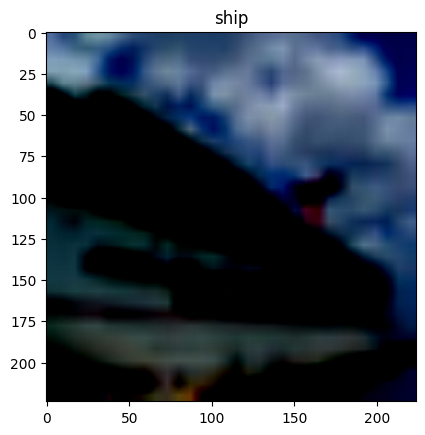

In [112]:
ind_test = np.random.randint(0, len(testset), 1)[0]
test_image = testset[ind_test][0].to(device)

model.eval()
with torch.no_grad():
    output = model(test_image.unsqueeze(0))
    _, predicted = torch.max(output.data, 1)

import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.transpose(testset[ind_test][0].numpy(), (1, 2, 0)))
plt.title(classes[predicted.item()])
plt.show()


In [117]:
# Export the model to ONNX
dummy_input = torch.randn(1, 3, 224, 224).to(device)
device = "cpu"
model.to(device)
dummy_input = dummy_input.to(device)
torch.onnx.export(model, dummy_input, "cat_detector.onnx")
# torch.save(model.state_dict(), 'model.pth')

OnnxExporterError: Module onnx is not installed!